In [186]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})

# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 18, 6
rcParams['font.size'] = 16
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 13
rcParams['ytick.labelsize'] = 13

In [187]:
import pandas as pd
import numpy as np

# Данные

Возьмите данные с https://www.kaggle.com/c/shelter-animal-outcomes .

Обратите внимание, что в этот раз у нас много классов, почитайте в разделе __Evaluation__ то, как вычисляется итоговый счет (score).

# Визуализация

<div class="panel panel-info" style="margin: 50px 0 0 0">
    <div class="panel-heading">
        <h3 class="panel-title">Задание 1.</h3> 
    </div>
</div>

Выясните, построив необходимые графики, влияет ли возраст, пол или фертильность животного на его шансы быть взятыми из приюта.

#### Подготовим данные 

In [188]:
visual = pd.read_csv('data/CatsAndDogs/train.csv')

#Сделаем числовой столбец Outcome, показывающий, взяли животное из приюта или нет
#Сначала заполним единицами, типа во всех случах хорошо
visual['Outcome'] = 'true'
#Неудачные случаи занулим
visual.loc[visual.OutcomeType == 'Euthanasia', 'Outcome'] = 'false'
visual.loc[visual.OutcomeType == 'Died', 'Outcome'] = 'false'

#Заменим строки, где в SexuponOutcome NaN, на что-нибудь осмысленное
visual.loc[visual.SexuponOutcome.isnull(), 'SexuponOutcome'] = 'Unknown Unknown'

#Сделаем два отдельных столбца для пола и фертильности
visual['Gender'] = visual.SexuponOutcome.apply(lambda s: s.split(' ')[-1])
visual['Fertility'] = visual.SexuponOutcome.apply(lambda s: s.split(' ')[0])

#### Сравним по возрасту

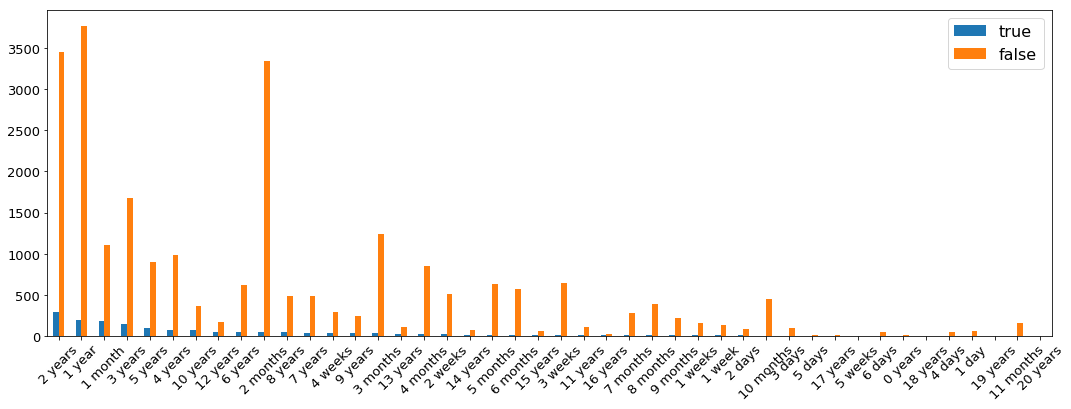

In [189]:
mergedByAges = visual.groupby('AgeuponOutcome')['Outcome'].value_counts().to_dict()

results = pd.DataFrame(data = mergedByAges, index=[0]).stack().fillna(0).transpose()
results.columns = pd.Index(['true', 'false'])
results['total'] = results.true + results.false
results.sort_values(by='true', ascending=False, inplace=True)
results[['true', 'false']].plot(kind='bar', stacked=False, rot=45);

#### Сравним по полу

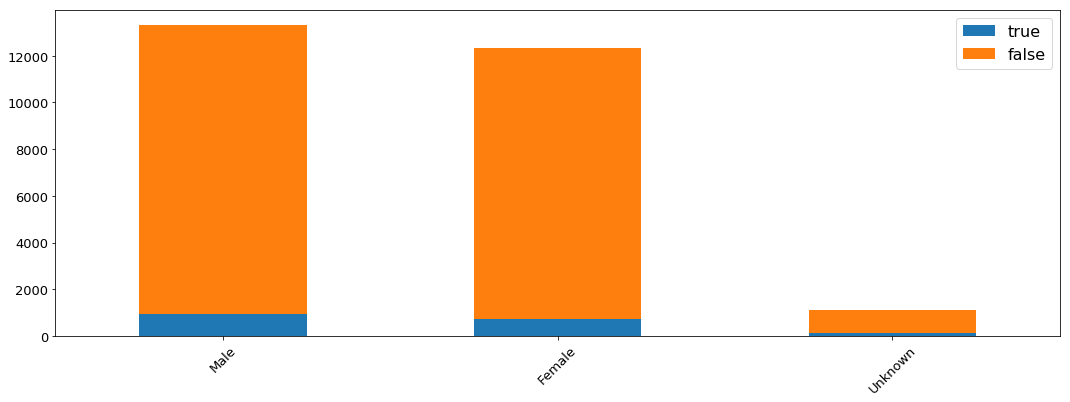

In [190]:
mergedByGender = visual.groupby('Gender')['Outcome'].value_counts().to_dict()

results = pd.DataFrame(data = mergedByGender, index=[0]).stack().fillna(0).transpose()
results.columns = pd.Index(['true', 'false'])
results['total'] = results.true + results.false
results.sort_values(by='true', ascending=False, inplace=True)
results[['true', 'false']].plot(kind='bar', stacked=True, rot=45);

#### Сравним по фертильности

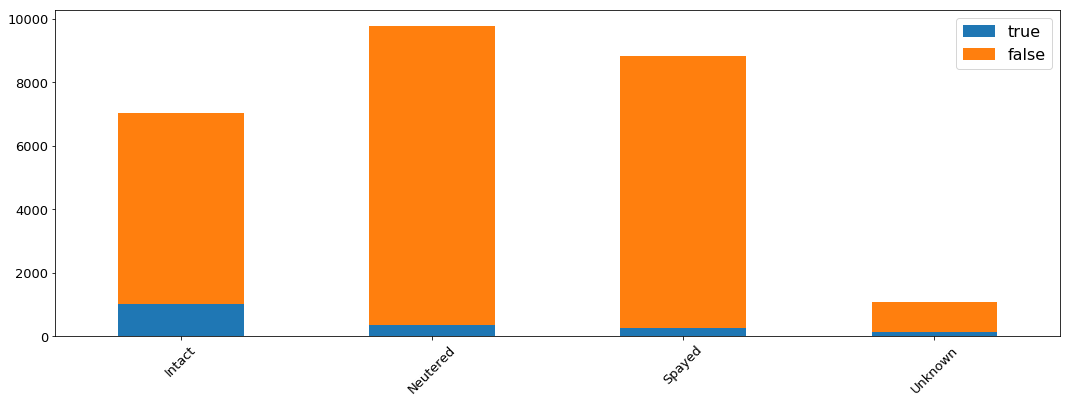

In [191]:
mergedByFert = visual.groupby('Fertility')['Outcome'].value_counts().to_dict()

results = pd.DataFrame(data = mergedByFert, index=[0]).stack().fillna(0).transpose()
results.columns = pd.Index(['true', 'false'])
results['total'] = results.true + results.false
results.sort_values(by='true', ascending=False, inplace=True)
results[['true', 'false']].plot(kind='bar', stacked=True, rot=45);

<b>Вывод по возрасту:</b> лучше берут не самых старых, но и не самых молодых
<br>
<b>Вывод по полу:</b> по большому счёту не имеет значения
<br>
<b>Вывод по фертильности:</b> лучше берут животных с ненарушенными репродуктивными способностями. Однако две следующие группы не сильно различаются по сути и, если их сложить, то разница не столь велика.

# Построение моделей

<div class="panel panel-info" style="margin: 50px 0 0 0">
    <div class="panel-heading">
        <h3 class="panel-title">Задание 2.</h3> 
    </div>
</div>

Посмотрите тетрадку с генерацией новых признаков. Сделайте как можно больше релевантных признаков из всех имеющихся.

Не забудьте параллельно обрабатывать отложенную выборку (__test__), чтобы в ней были те же самые признаки, что и в обучающей.

<b>Возьмем исходные данные</b>

In [192]:
train, test = pd.read_csv(
    'data/CatsAndDogs/train.csv' #исходные данные
), pd.read_csv(
    'data/CatsAndDogs/test.csv'  #исходные данные
)

train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [193]:
test.shape

(11456, 8)

<b>Добавим новые признаки в train</b>

In [194]:
#Сначала по-аналогии с визуализацией

#Заменим строки, где в SexuponOutcome, Breed, Color NaN
train.loc[train.SexuponOutcome.isnull(), 'SexuponOutcome'] = 'Unknown Unknown'
train.loc[train.AgeuponOutcome.isnull(), 'AgeuponOutcome'] = '0 0'
train.loc[train.Breed.isnull(), 'Breed'] = 'Unknown'
train.loc[train.Color.isnull(), 'Color'] = 'Unknown'

#Сделаем два отдельных столбца для пола и фертильности
train['Gender'] = train.SexuponOutcome.apply(lambda s: s.split(' ')[-1])
train['Fertility'] = train.SexuponOutcome.apply(lambda s: s.split(' ')[0])

#Теперь что-то новое

#Столбец, в котором отмечено, есть имя у животного или нет
train['hasName'] = 1
train.loc[train.Name.isnull(), 'hasName'] = 0

#Столбец, в котором объединены порода и цвет
train['breedColor'] = train.apply(lambda row: row['Breed'] + ' ' + str(row['Color']), axis=1)

#Декомпозируем DateTime
#Во-первых, конвертируем столбец в тип DateTime из строкового
train['DateTime'] = pd.to_datetime(train['DateTime'])
#А теперь декомпозируем
train['dayOfWeek'] = train.DateTime.apply(lambda dt: dt.dayofweek)
train['month'] = train.DateTime.apply(lambda dt: dt.month)
train['day'] = train.DateTime.apply(lambda dt: dt.day)
train['quarter'] = train.DateTime.apply(lambda dt: dt.quarter)
train['hour'] = train.DateTime.apply(lambda dt: dt.hour)
train['minute'] = train.DateTime.apply(lambda dt: dt.hour)
train['year'] = train.DateTime.apply(lambda dt: dt.year)

#Разбиение возраста
#Сделаем два отдельных столбца для обозначения года/месяца и их количества
train['AgeuponFirstPart'] = train.AgeuponOutcome.apply(lambda s: s.split(' ')[0])
train['AgeuponSecondPart'] = train.AgeuponOutcome.apply(lambda s: s.split(' ')[-1])
#Переведем примерно в среднем месяцы, годы и недели в дни с учетом окончаний s
train['AgeuponSecondPartInDays'] = 0
train.loc[train.AgeuponSecondPart == 'year', 'AgeuponSecondPartInDays'] = 365
train.loc[train.AgeuponSecondPart == 'years', 'AgeuponSecondPartInDays'] = 365
train.loc[train.AgeuponSecondPart == 'month', 'AgeuponSecondPartInDays'] = 30
train.loc[train.AgeuponSecondPart == 'months', 'AgeuponSecondPartInDays'] = 30
train.loc[train.AgeuponSecondPart == 'week', 'AgeuponSecondPartInDays'] = 7
train.loc[train.AgeuponSecondPart == 'weeks', 'AgeuponSecondPartInDays'] = 7
#Во-первых, конвертируем столбец в числовой тип из строкового
train['AgeuponFirstPart'] = pd.to_numeric(train['AgeuponFirstPart'])
train['AgeuponSecondPartInDays'] = pd.to_numeric(train['AgeuponSecondPartInDays'])

#А теперь получим нормальное время жизни в днях
train['LifetimeInDays'] = train['AgeuponFirstPart'] * train['AgeuponSecondPartInDays']

#Удалим уж совсем бессмысленные промежуточные столбцы
train = train.drop(['AgeuponSecondPartInDays', 'AgeuponSecondPart', 'AgeuponFirstPart', 'OutcomeSubtype'], axis=1)
train.head()

,AnimalID,Name,DateTime,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Gender,...,hasName,breedColor,dayOfWeek,month,day,quarter,hour,minute,year,LifetimeInDays
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,Male,...,1,Shetland Sheepdog Mix Brown/White,2,2,12,1,18,18,2014,365
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,Female,...,1,Domestic Shorthair Mix Cream Tabby,6,10,13,4,12,12,2013,365
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,Male,...,1,Pit Bull Mix Blue/White,5,1,31,1,12,12,2015,730
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,Male,...,0,Domestic Shorthair Mix Blue Cream,4,7,11,3,19,19,2014,21
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,Male,...,0,Lhasa Apso/Miniature Poodle Tan,4,11,15,4,12,12,2013,730


<b>Добавим новые признаки в test по-аналогии</b>

In [195]:
#Сначала по-аналогии с визуализацией

#Заменим строки, где в SexuponOutcome, Breed, Color NaN
test.loc[test.SexuponOutcome.isnull(), 'SexuponOutcome'] = 'Unknown Unknown'
test.loc[test.AgeuponOutcome.isnull(), 'AgeuponOutcome'] = '0 0'
test.loc[test.Breed.isnull(), 'Breed'] = 'Unknown'
test.loc[test.Color.isnull(), 'Color'] = 'Unknown'

#Сделаем два отдельных столбца для пола и фертильности
test['Gender'] = test.SexuponOutcome.apply(lambda s: s.split(' ')[-1])
test['Fertility'] = test.SexuponOutcome.apply(lambda s: s.split(' ')[0])

#Теперь что-то новое

#Столбец, в котором отмечено, есть имя у животного или нет
test['hasName'] = 1
test.loc[test.Name.isnull(), 'hasName'] = 0

#Столбец, в котором объединены порода и цвет
test['breedColor'] = test.apply(lambda row: row['Breed'] + ' ' + str(row['Color']), axis=1)

#Декомпозируем DateTime
#Во-первых, конвертируем столбец в тип DateTime из строкового
test['DateTime'] = pd.to_datetime(test['DateTime'])
#А теперь декомпозируем
test['dayOfWeek'] = test.DateTime.apply(lambda dt: dt.dayofweek)
test['month'] = test.DateTime.apply(lambda dt: dt.month)
test['day'] = test.DateTime.apply(lambda dt: dt.day)
test['quarter'] = test.DateTime.apply(lambda dt: dt.quarter)
test['hour'] = test.DateTime.apply(lambda dt: dt.hour)
test['minute'] = test.DateTime.apply(lambda dt: dt.hour)
test['year'] = test.DateTime.apply(lambda dt: dt.year)

#Разбиение возраста
#Сделаем два отдельных столбца для обозначения года/месяца и их количества
test['AgeuponFirstPart'] = test.AgeuponOutcome.apply(lambda s: s.split(' ')[0])
test['AgeuponSecondPart'] = test.AgeuponOutcome.apply(lambda s: s.split(' ')[-1])
#Переведем примерно в среднем месяцы, годы и недели в дни с учетом окончаний s
test['AgeuponSecondPartInDays'] = 0
test.loc[test.AgeuponSecondPart == 'year', 'AgeuponSecondPartInDays'] = 365
test.loc[test.AgeuponSecondPart == 'years', 'AgeuponSecondPartInDays'] = 365
test.loc[test.AgeuponSecondPart == 'month', 'AgeuponSecondPartInDays'] = 30
test.loc[test.AgeuponSecondPart == 'months', 'AgeuponSecondPartInDays'] = 30
test.loc[test.AgeuponSecondPart == 'week', 'AgeuponSecondPartInDays'] = 7
test.loc[test.AgeuponSecondPart == 'weeks', 'AgeuponSecondPartInDays'] = 7
#Во-первых, конвертируем столбец в числовой тип из строкового
test['AgeuponFirstPart'] = pd.to_numeric(test['AgeuponFirstPart'])
test['AgeuponSecondPartInDays'] = pd.to_numeric(test['AgeuponSecondPartInDays'])

#А теперь получим нормальное время жизни в днях
test['LifetimeInDays'] = test['AgeuponFirstPart'] * test['AgeuponSecondPartInDays']

#Удалим уж совсем бессмысленные промежуточные столбцы
test = test.drop(['AgeuponSecondPartInDays', 'AgeuponSecondPart', 'AgeuponFirstPart'], axis=1)

test.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Gender,Fertility,hasName,breedColor,dayOfWeek,month,day,quarter,hour,minute,year,LifetimeInDays
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White,Female,Intact,1,Labrador Retriever Mix Red/White,0,10,12,4,12,12,2015,300
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan,Female,Spayed,1,German Shepherd/Siberian Husky Black/Tan,5,7,26,3,17,17,2014,730
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby,Male,Neutered,1,Domestic Shorthair Mix Brown Tabby,2,1,13,1,12,12,2016,365
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor,Male,Intact,1,Collie Smooth Mix Tricolor,5,12,28,4,18,18,2013,120
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White,Male,Neutered,1,Miniature Poodle Mix White,3,9,24,3,17,17,2015,730


<div class="panel panel-info" style="margin: 50px 0 0 0">
    <div class="panel-heading">
        <h3 class="panel-title">Задание 3.</h3> 
    </div>
</div>

Выполните отбор признаков, попробуйте различные методы. Проверьте качество на кросс-валидации. 

Выведите топ самых важных и самых незначащих признаков.

#### Предобработка данных

In [196]:
np.random.seed = 1234
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

#####################Заменим NaN значения на слово Unknown##################
#Уберем Nan значения из train
train.loc[train.AnimalID.isnull(), 'AnimalID'] = 'Unknown'
train.loc[train.Name.isnull(), 'Name'] = 'Unknown'
train.loc[train.OutcomeType.isnull(), 'OutcomeType'] = 'Unknown'
train.loc[train.AnimalType.isnull(), 'AnimalType'] = 'Unknown'
train.loc[train.AgeuponOutcome.isnull(), 'AgeuponOutcome'] = 'Unknown'
train.loc[train.LifetimeInDays.isnull(), 'LifetimeInDays'] = 'Unknown'

#Уберем Nan значения из test
test.loc[test.ID.isnull(), 'ID'] = 'Unknown'
test.loc[test.Name.isnull(), 'Name'] = 'Unknown'
test.loc[test.AnimalType.isnull(), 'AnimalType'] = 'Unknown'
test.loc[test.AgeuponOutcome.isnull(), 'AgeuponOutcome'] = 'Unknown'
test.loc[test.LifetimeInDays.isnull(), 'LifetimeInDays'] = 'Unknown'

#####################Закодируем слова числами################################

#Закодировали AnimalID цифрами вместо названий в test & train
#encAnimalID = preprocessing.LabelEncoder()
#encAnimalID.fit(pd.concat((test['AnimalID'], train['AnimalID'])))
#test['AnimalID'] = encAnimalID.transform(test['AnimalID'])
#train['AnimalID'] = encAnimalID.transform(train['AnimalID'])

#Закодировали имя цифрами вместо названий в test & train
encName = preprocessing.LabelEncoder()
encName.fit(pd.concat((test['Name'], train['Name'])))
test['Name'] = encName.transform(test['Name'])
train['Name'] = encName.transform(train['Name'])

#Закодировали DateTime цифрами вместо названий в test & train
encDateTime = preprocessing.LabelEncoder()
encDateTime.fit(pd.concat((test['DateTime'], train['DateTime'])))
test['DateTime'] = encDateTime.transform(test['DateTime'])
train['DateTime'] = encDateTime.transform(train['DateTime'])

#Закодировали OutcomeType цифрами вместо названий в train, т.к. в test их нет
encOutcomeType = preprocessing.LabelEncoder()
encOutcomeType.fit(train['OutcomeType'])
train['OutcomeType'] = encOutcomeType.transform(train['OutcomeType'])

#Закодировали AnimalType цифрами вместо названий в test & train
encAnimalType = preprocessing.LabelEncoder()
encAnimalType.fit(pd.concat((test['AnimalType'], train['AnimalType'])))
test['AnimalType'] = encAnimalType.transform(test['AnimalType'])
train['AnimalType'] = encAnimalType.transform(train['AnimalType'])

#Закодировали SexuponOutcome цифрами вместо названий в test & train
encSexuponOutcome = preprocessing.LabelEncoder()
encSexuponOutcome.fit(pd.concat((test['SexuponOutcome'], train['SexuponOutcome'])))
test['SexuponOutcome'] = encSexuponOutcome.transform(test['SexuponOutcome'])
train['SexuponOutcome'] = encSexuponOutcome.transform(train['SexuponOutcome'])

#Закодировали AgeuponOutcome цифрами вместо названий в test & train
encAgeuponOutcome = preprocessing.LabelEncoder()
encAgeuponOutcome.fit(pd.concat((test['AgeuponOutcome'], train['AgeuponOutcome'])))
test['AgeuponOutcome'] = encAgeuponOutcome.transform(test['AgeuponOutcome'])
train['AgeuponOutcome'] = encAgeuponOutcome.transform(train['AgeuponOutcome'])

#Закодировали Breed цифрами вместо названий в test & train
encBreed = preprocessing.LabelEncoder()
encBreed.fit(pd.concat((test['Breed'], train['Breed'])))
test['Breed'] = encBreed.transform(test['Breed'])
train['Breed'] = encBreed.transform(train['Breed'])

#Закодировали Color цифрами вместо названий в test & train
encColor = preprocessing.LabelEncoder()
encColor.fit(pd.concat((test['Color'], train['Color'])))
test['Color'] = encColor.transform(test['Color'])
train['Color'] = encColor.transform(train['Color'])

#Закодировали Gender цифрами вместо названий в test & train
encGender = preprocessing.LabelEncoder()
encGender.fit(pd.concat((test['Gender'], train['Gender'])))
test['Gender'] = encGender.transform(test['Gender'])
train['Gender'] = encGender.transform(train['Gender'])

#Закодировали Fertility цифрами вместо названий в test & train
encFertility = preprocessing.LabelEncoder()
encFertility.fit(pd.concat((test['Fertility'], train['Fertility'])))
test['Fertility'] = encFertility.transform(test['Fertility'])
train['Fertility'] = encFertility.transform(train['Fertility'])

#Закодировали breedColor цифрами вместо названий в test & train
encbreedColor = preprocessing.LabelEncoder()
encbreedColor.fit(pd.concat((test['breedColor'], train['breedColor'])))
test['breedColor'] = encbreedColor.transform(test['breedColor'])
train['breedColor'] = encbreedColor.transform(train['breedColor'])

####################################Предобработка#################################
from sklearn.model_selection import cross_val_score
#poly_features = preprocessing.PolynomialFeatures(3)

#Подготовили данные так, что X_tr - таблица без AnimalID и OutcomeType, а в y_tr сохранены OutcomeType
X_tr, y_tr = train.drop(['AnimalID', 'OutcomeType'], axis=1), train['OutcomeType']

#Типа перевели dataFrame в array и сдалали над ним предварительную обработку
#X_tr = poly_features.fit_transform(X_tr)
X_tr.head()

,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Gender,Fertility,hasName,breedColor,dayOfWeek,month,day,quarter,hour,minute,year,LifetimeInDays
0,2910,4641,1,2,6,1482,146,1,1,1,5907,2,2,12,1,18,18,2014,365
1,2265,482,0,3,6,775,184,0,2,1,3161,6,10,13,4,12,12,2013,365
2,5500,17382,1,2,22,1293,97,1,1,1,5167,5,1,31,1,12,12,2015,730
3,7563,9918,0,1,27,775,47,1,0,0,3115,4,7,11,3,19,19,2014,21
4,7563,1710,1,2,22,1101,311,1,1,0,4496,4,11,15,4,12,12,2013,730


#### Статистические тесты

In [77]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

skb = SelectKBest(mutual_info_classif, k=15)
x_new = skb.fit_transform(X_tr, y_tr)

In [78]:
x_new

array([[ 2910,  4641,     1, ...,    18,    18,   365],
       [ 2265,   482,     0, ...,    12,    12,   365],
       [ 5500, 17382,     1, ...,    12,    12,   730],
       ..., 
       [ 7917, 18474,     1, ...,    13,    13,  1460],
       [ 7563,  6971,     0, ...,    12,    12,    28],
       [ 7563, 22720,     0, ...,     9,     9,   365]], dtype=int64)

#### Методы обертки

In [37]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

names = X_tr.columns.values
lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(X_tr,y_tr);
print("Features sorted by their rank:")
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names)))

Features sorted by their rank:
[(1, 'hasName'), (2, 'SexuponOutcome'), (3, 'Fertility'), (4, 'Gender'), (5, 'AnimalType'), (6, 'minute'), (7, 'dayOfWeek'), (8, 'year'), (9, 'hour'), (10, 'quarter'), (11, 'month'), (12, 'AgeuponOutcome'), (13, 'day'), (14, 'Breed'), (15, 'breedColor'), (16, 'DateTime'), (17, 'LifetimeInDays'), (18, 'Color'), (19, 'Name')]


#### Отбор при помощи модели Lasso

In [38]:
from sklearn.linear_model import Lasso
clf = Lasso()
clf.fit(X_tr, y_tr);
clf.coef_

array([  1.32815180e-04,  -6.01469735e-06,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,  -6.62069276e-05,
        -1.01156049e-04,   0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,   4.29665215e-05,  -0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
        -3.89186259e-02,  -1.22206726e-17,   0.00000000e+00,
         1.39384436e-04])

In [39]:
features = X_tr.columns.values
print('Всего Lasso выкинуло %s переменных' % (clf.coef_ == 0).sum())
print('Это признаки:')
for s in features[np.where(clf.coef_ == 0)[0]]:
    print(' * ', s)

Всего Lasso выкинуло 11 переменных
Это признаки:
 *  AnimalType
 *  SexuponOutcome
 *  AgeuponOutcome
 *  Gender
 *  Fertility
 *  hasName
 *  dayOfWeek
 *  month
 *  day
 *  quarter
 *  year


#### Отбор при помощи модели RandomForest

In [40]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()
clf.fit(X_tr, y_tr);
clf.feature_importances_

array([ 0.08162756,  0.09685043,  0.0131945 ,  0.0986221 ,  0.02264239,
        0.02960729,  0.05798159,  0.01715237,  0.14918959,  0.01151453,
        0.0604392 ,  0.04677268,  0.03326102,  0.06664657,  0.0089478 ,
        0.04198525,  0.04332425,  0.0045843 ,  0.11565658])

In [41]:
imp_feature_idx = clf.feature_importances_.argsort()
imp_feature_idx

array([17, 14,  9,  2,  7,  4,  5, 12, 15, 16, 11,  6, 10, 13,  0,  1,  3,
       18,  8], dtype=int64)

In [42]:
features = X_tr.columns.values

k = 0

while k < len(features):
    print(features[k], imp_feature_idx[k])
    k += 1

Name 17
DateTime 14
AnimalType 9
SexuponOutcome 2
AgeuponOutcome 7
Breed 4
Color 5
Gender 12
Fertility 15
hasName 16
breedColor 11
dayOfWeek 6
month 10
day 13
quarter 0
hour 1
minute 3
year 18
LifetimeInDays 8


<b>Вывод по признакам:</b>
<br>
<b>Не нужны:</b> Name, DateTime, month, day, Breed, breedColor. Всё остальное менее однозначно, можно и оставить.

<div class="panel panel-info" style="margin: 50px 0 0 0">
    <div class="panel-heading">
        <h3 class="panel-title">Задание 4.</h3> 
    </div>
</div>

Попробуйте смешать разные модели с помощью <b>sklearn.ensemble.VotingClassifier</b>. Увеличилась ли точность? Изменилась ли дисперсия?

In [197]:
#Для начала выкинем ненужные признаки, выявленные на прошлом этапе
X_tr = X_tr.drop(['Name', 'DateTime', 'month', 'day', 'breedColor', 'Breed'], axis=1)
test = test.drop(['Name', 'DateTime', 'month', 'day', 'breedColor', 'Breed'], axis=1)
X_tr.head()

,AnimalType,SexuponOutcome,AgeuponOutcome,Color,Gender,Fertility,hasName,dayOfWeek,quarter,hour,minute,year,LifetimeInDays
0,1,2,6,146,1,1,1,2,1,18,18,2014,365
1,0,3,6,184,0,2,1,6,4,12,12,2013,365
2,1,2,22,97,1,1,1,5,1,12,12,2015,730
3,0,1,27,47,1,0,0,4,3,19,19,2014,21
4,1,2,22,311,1,1,0,4,4,12,12,2013,730


In [235]:
from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

clf1 = LogisticRegression(random_state=1234)
clf3 = GaussianNB()
clf4 = RandomForestClassifier(random_state=1234)
clf5 = KNeighborsClassifier()

eclf = VotingClassifier(estimators=[
    ('lr', clf1), ('gnb', clf3), ('knn', clf5), ('rf', clf4)],
                         voting='soft', weights=[1,1,2,4])

scores = cross_val_score(eclf, X_tr, y_tr)

eclf = eclf.fit(X_tr, y_tr)

In [236]:
print('Best score:', scores.min())

Best score: 0.655106621773


In [237]:
#delete AnimalID from test
X_te = test.drop(['ID'], axis=1)
X_te.head()

,AnimalType,SexuponOutcome,AgeuponOutcome,Color,Gender,Fertility,hasName,dayOfWeek,quarter,hour,minute,year,LifetimeInDays
0,1,0,7,283,0,0,1,0,4,12,12,2015,300
1,1,3,22,40,0,2,1,5,3,17,17,2014,730
2,0,2,6,117,1,1,1,2,1,12,12,2016,365
3,1,1,30,346,1,0,1,5,4,18,18,2013,120
4,1,2,22,359,1,1,1,3,3,17,17,2015,730


In [238]:
ids = test[['ID']]

result = pd.concat([ids,pd.DataFrame(data = eclf.predict_proba(X_te), columns = encOutcomeType.classes_)], axis=1)
result.head()

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,0.107592,0.001914,0.019537,0.090302,0.780655
1,2,0.740291,0.000081,0.001337,0.148976,0.109315
2,3,0.224183,0.003577,0.007107,0.360442,0.404690
3,4,0.377313,0.000274,0.056867,0.117928,0.447618
4,5,0.569276,0.000220,0.003767,0.352355,0.074382


In [239]:
#Сохраним
result.to_csv('ans_catdog_basic.csv', index=False)